# Import des librairies nécessaires

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Pré-traitement des données

## Ouverture du jeu de données et informations générales

In [56]:
data = pd.read_csv("fetal_health.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [57]:
data_with_fetal_health = data.copy()

In [58]:
data_descriptions = {
    'baseline_value': 'Fréquence cardiaque fœtale de base (FCF)',
    'accelerations': 'Nombre d\'accélérations par seconde',
    'fetal_movement': 'Nombre de mouvements fœtaux par seconde',
    'uterine_contractions': 'Nombre de contractions utérines par seconde',
    'light_decelerations': 'Nombre de décélérations légères par seconde',
    'severe_decelerations': 'Nombre de décélérations sévères par seconde',
    'prolongued_decelerations': 'Nombre de décélérations prolongées par seconde',
    'abnormal_short_term_variability': 'Pourcentage de temps avec une variabilité à court terme anormale',
    'mean_value_of_short_term_variability': 'Valeur moyenne de la variabilité à court terme',
    'percentage_of_time_with_abnormal_long_term_variability': 'Pourcentage de temps avec une variabilité à long terme anormale',
    'mean_value_of_long_term_variability': 'Valeur moyenne de la variabilité à long terme',
    'histogram_width': 'Largeur de l\'histogramme utilisant toutes les valeurs d\'un enregistrement',
    'histogram_min': 'Valeur minimale de l\'histogramme',
    'histogram_max': 'Valeur maximale de l\'histogramme',
    'histogram_number_of_peaks': 'Nombre de pics dans l\'histogramme de l\'examen',
    'histogram_number_of_zeroes': 'Nombre de zéros dans l\'histogramme de l\'examen',
    'histogram_mode': 'Mode de l\'histogramme',
    'histogram_mean': 'Moyenne de l\'histogramme',
    'histogram_median': 'Médiane de l\'histogramme',
    'histogram_variance': 'Variance de l\'histogramme',
    'histogram_tendency': 'Tendance de l\'histogramme',
    'fetal_health': 'Santé fœtale: 1 - Normal 2 - Suspect 3 - Pathologique'
}

df_descriptions = pd.DataFrame.from_dict(data_descriptions, orient='index', columns=['Description'])
print(df_descriptions)


                                                                                          Description
baseline_value                                               Fréquence cardiaque fœtale de base (FCF)
accelerations                                                      Nombre d'accélérations par seconde
fetal_movement                                                Nombre de mouvements fœtaux par seconde
uterine_contractions                                      Nombre de contractions utérines par seconde
light_decelerations                                       Nombre de décélérations légères par seconde
severe_decelerations                                      Nombre de décélérations sévères par seconde
prolongued_decelerations                               Nombre de décélérations prolongées par seconde
abnormal_short_term_variability                     Pourcentage de temps avec une variabilité à co...
mean_value_of_short_term_variability                   Valeur moyenne de la variab

Ici l'on peut voir que pandas interpréte correctement les différents types de données, sauf pour *fetal_health* qui dans notre cas devrait être catégorielle et ordonnée (3 est plus grave que 2 qui est plus grave que 1)

## Conversion de la variable *fetal_health* en variable qualitative ordinale

In [59]:
data.fetal_health = pd.Categorical(data.fetal_health, categories=[1.0, 2.0, 3.0], ordered=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   baseline value                                          2126 non-null   float64 
 1   accelerations                                           2126 non-null   float64 
 2   fetal_movement                                          2126 non-null   float64 
 3   uterine_contractions                                    2126 non-null   float64 
 4   light_decelerations                                     2126 non-null   float64 
 5   severe_decelerations                                    2126 non-null   float64 
 6   prolongued_decelerations                                2126 non-null   float64 
 7   abnormal_short_term_variability                         2126 non-null   float64 
 8   mean_value_of_short_term_var

## Affichage du nombre de valeurs différentes et du nombre de valeurs manquantes

In [60]:
print(f"Nombre de valeurs différentes par variables :\n{data.nunique()}")
print()
print(f"Nombre de valeurs manquantes par variables :\n{data.isna().sum()}")

Nombre de valeurs différentes par variables :
baseline value                                             48
accelerations                                              20
fetal_movement                                            102
uterine_contractions                                       16
light_decelerations                                        16
severe_decelerations                                        2
prolongued_decelerations                                    6
abnormal_short_term_variability                            75
mean_value_of_short_term_variability                       57
percentage_of_time_with_abnormal_long_term_variability     87
mean_value_of_long_term_variability                       249
histogram_width                                           154
histogram_min                                             109
histogram_max                                              86
histogram_number_of_peaks                                  18
histogram_number_of_zero

Ici on voit qu'aucune variable n'est constante (aucune variable n'a qu'une seule et unique valeur), et l'on remarque aussi que le jeu de données ne contient aucune valeurs vides, ce qui nous arrange pour la suite.

# Exploration et visualisation des données

## Effectifs de chaque classe

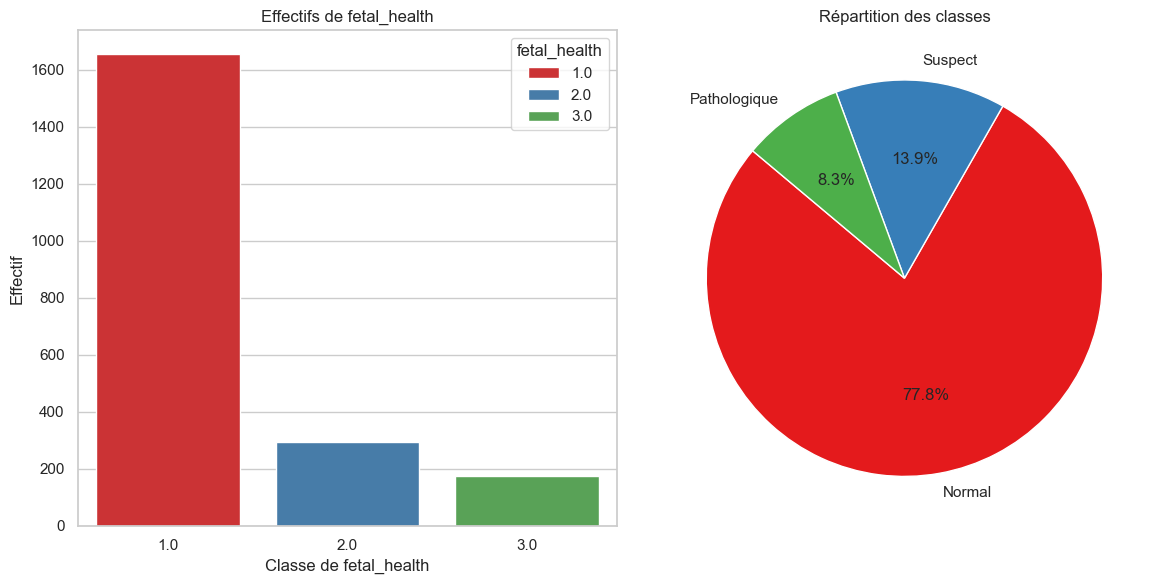

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x='fetal_health', hue="fetal_health", palette="Set1", data=data, ax=axes[0])
axes[0].set_title('Effectifs de fetal_health')
axes[0].set_xlabel('Classe de fetal_health')
axes[0].set_ylabel('Effectif')

plt.pie(data["fetal_health"].value_counts(normalize=True), labels=["Normal", "Suspect", "Pathologique"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set1'))
axes[1].set_title('Répartition des classes')
axes[1].set_ylabel('')

# plt.save_fig('repartition_classes.png')
plt.tight_layout()
plt.show()

On remarque un certain déséquilibre dans les classes de *fetal_health*, ce qui est normal.

## Statistiques descriptives de base

In [11]:
data.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


## Histogrammes de chaque variable avec decoupage en fonction de la classe

In [53]:
sns.set_context("notebook")


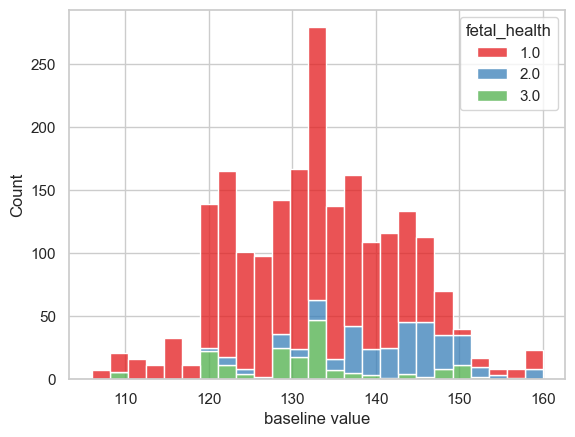

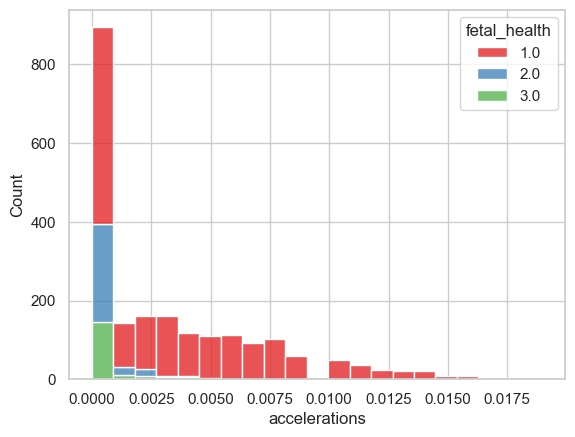

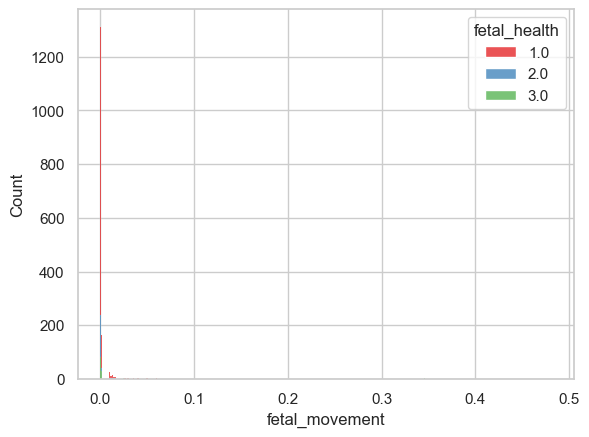

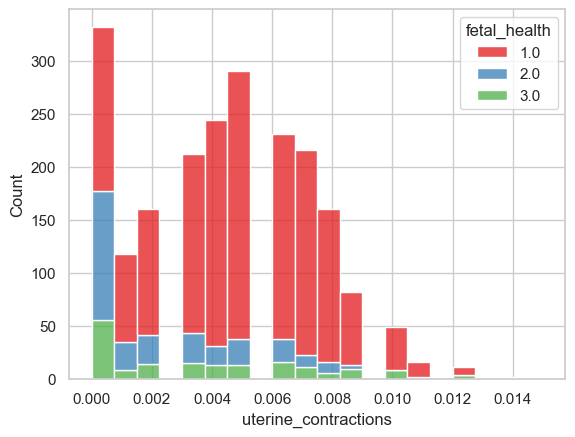

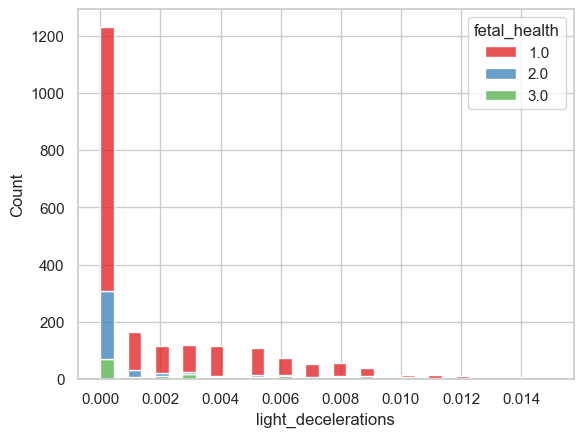

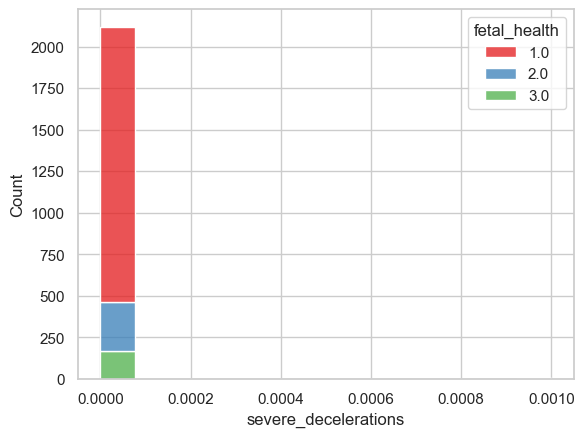

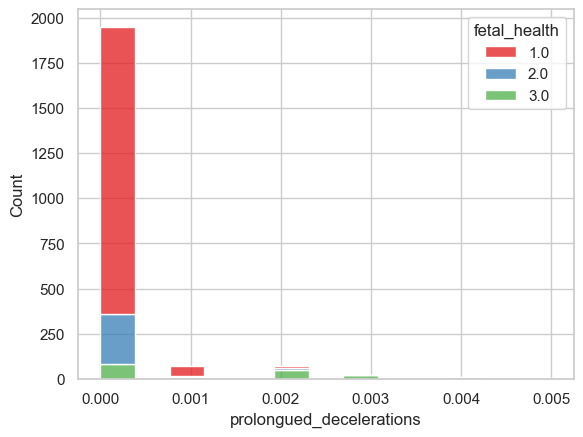

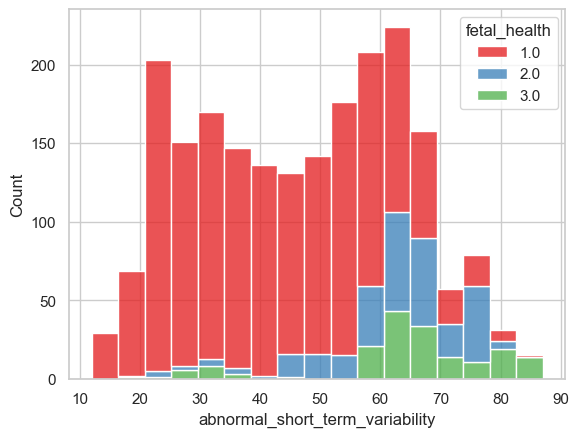

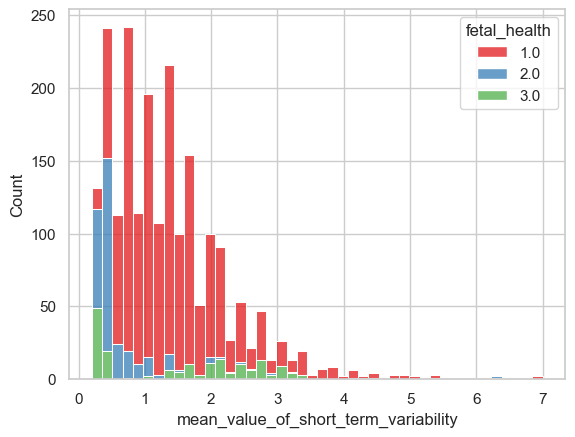

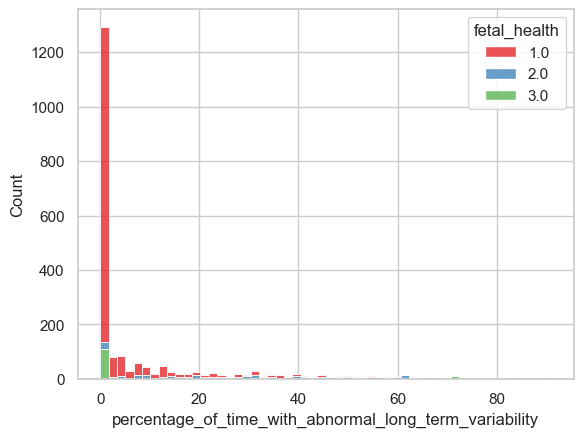

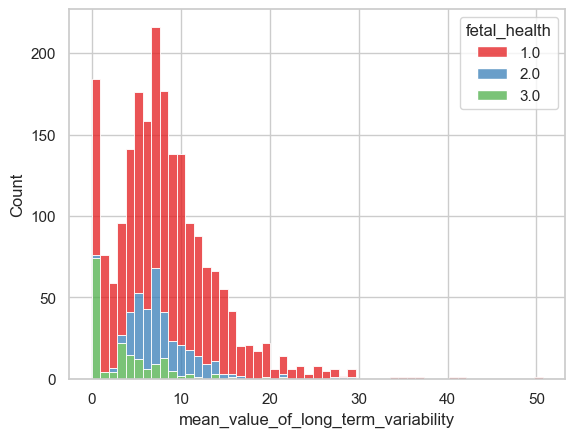

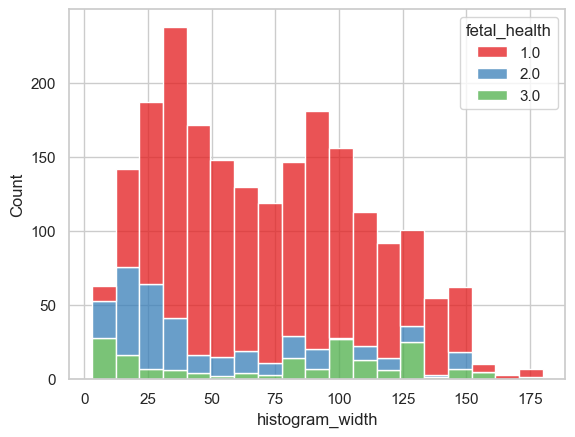

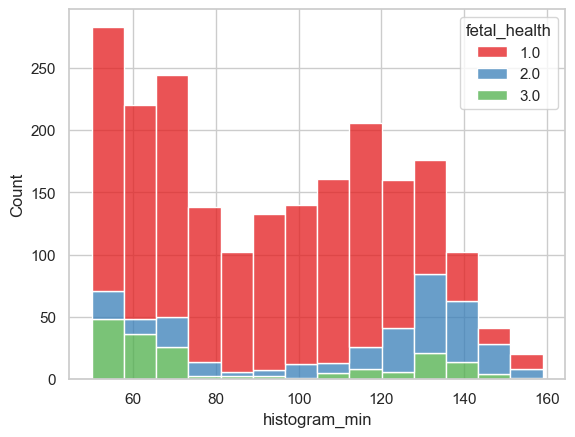

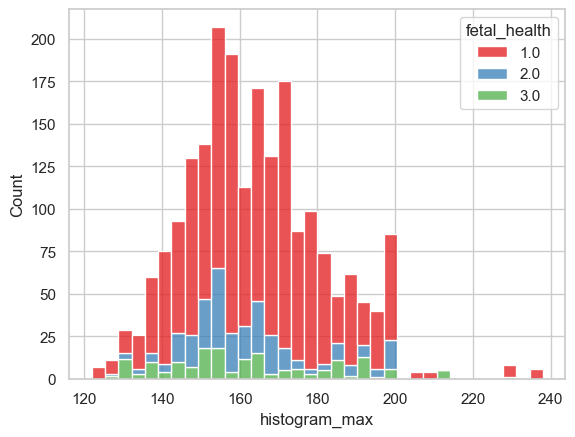

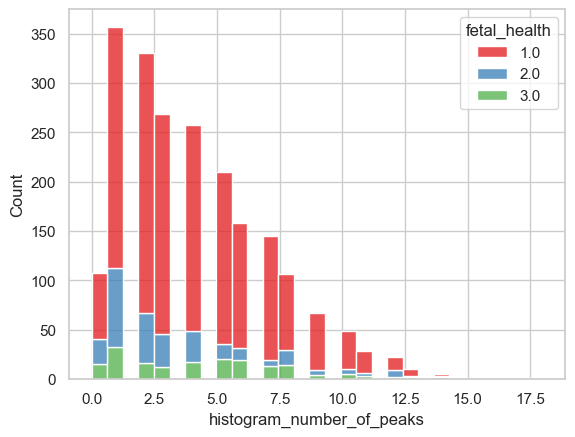

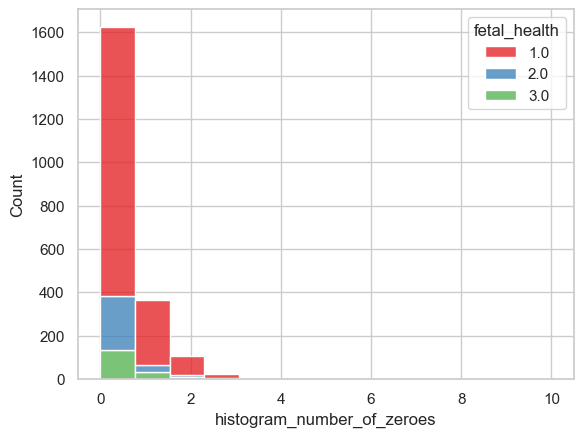

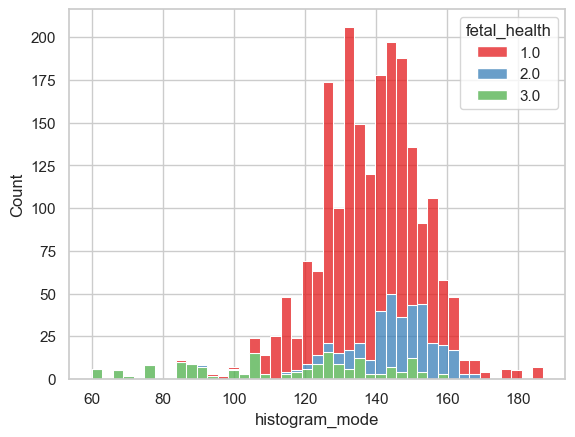

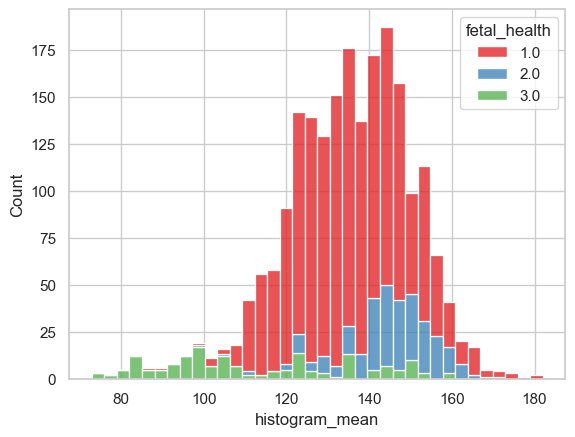

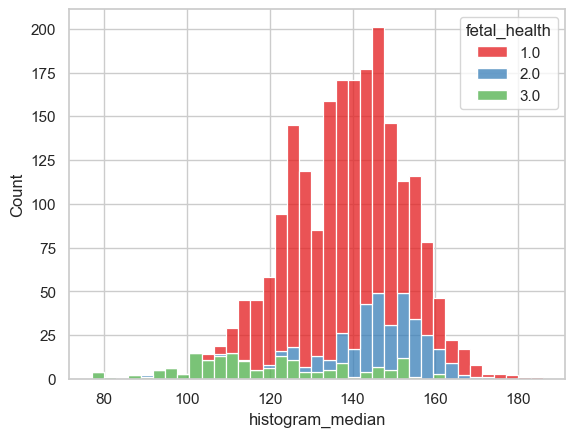

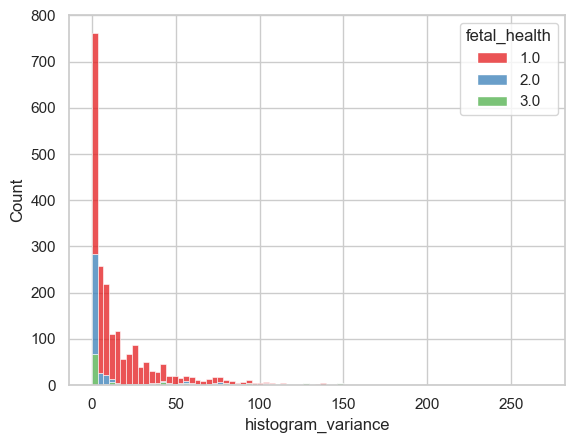

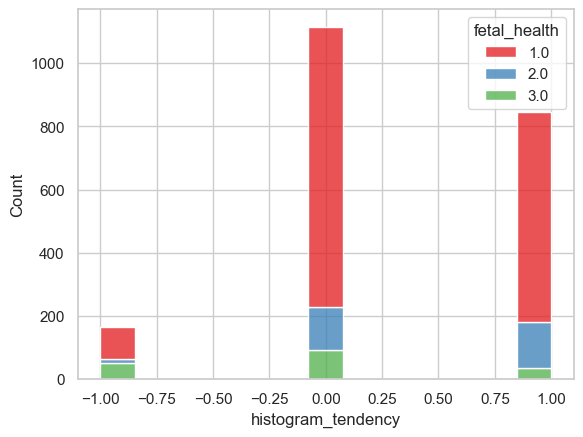

In [62]:
for column in data.columns:
    if column != "fetal_health":
        sns.histplot(x=column, hue="fetal_health", multiple="stack", palette="Set1", data=data)
        plt.show()

## Boxplot pour chaque variable

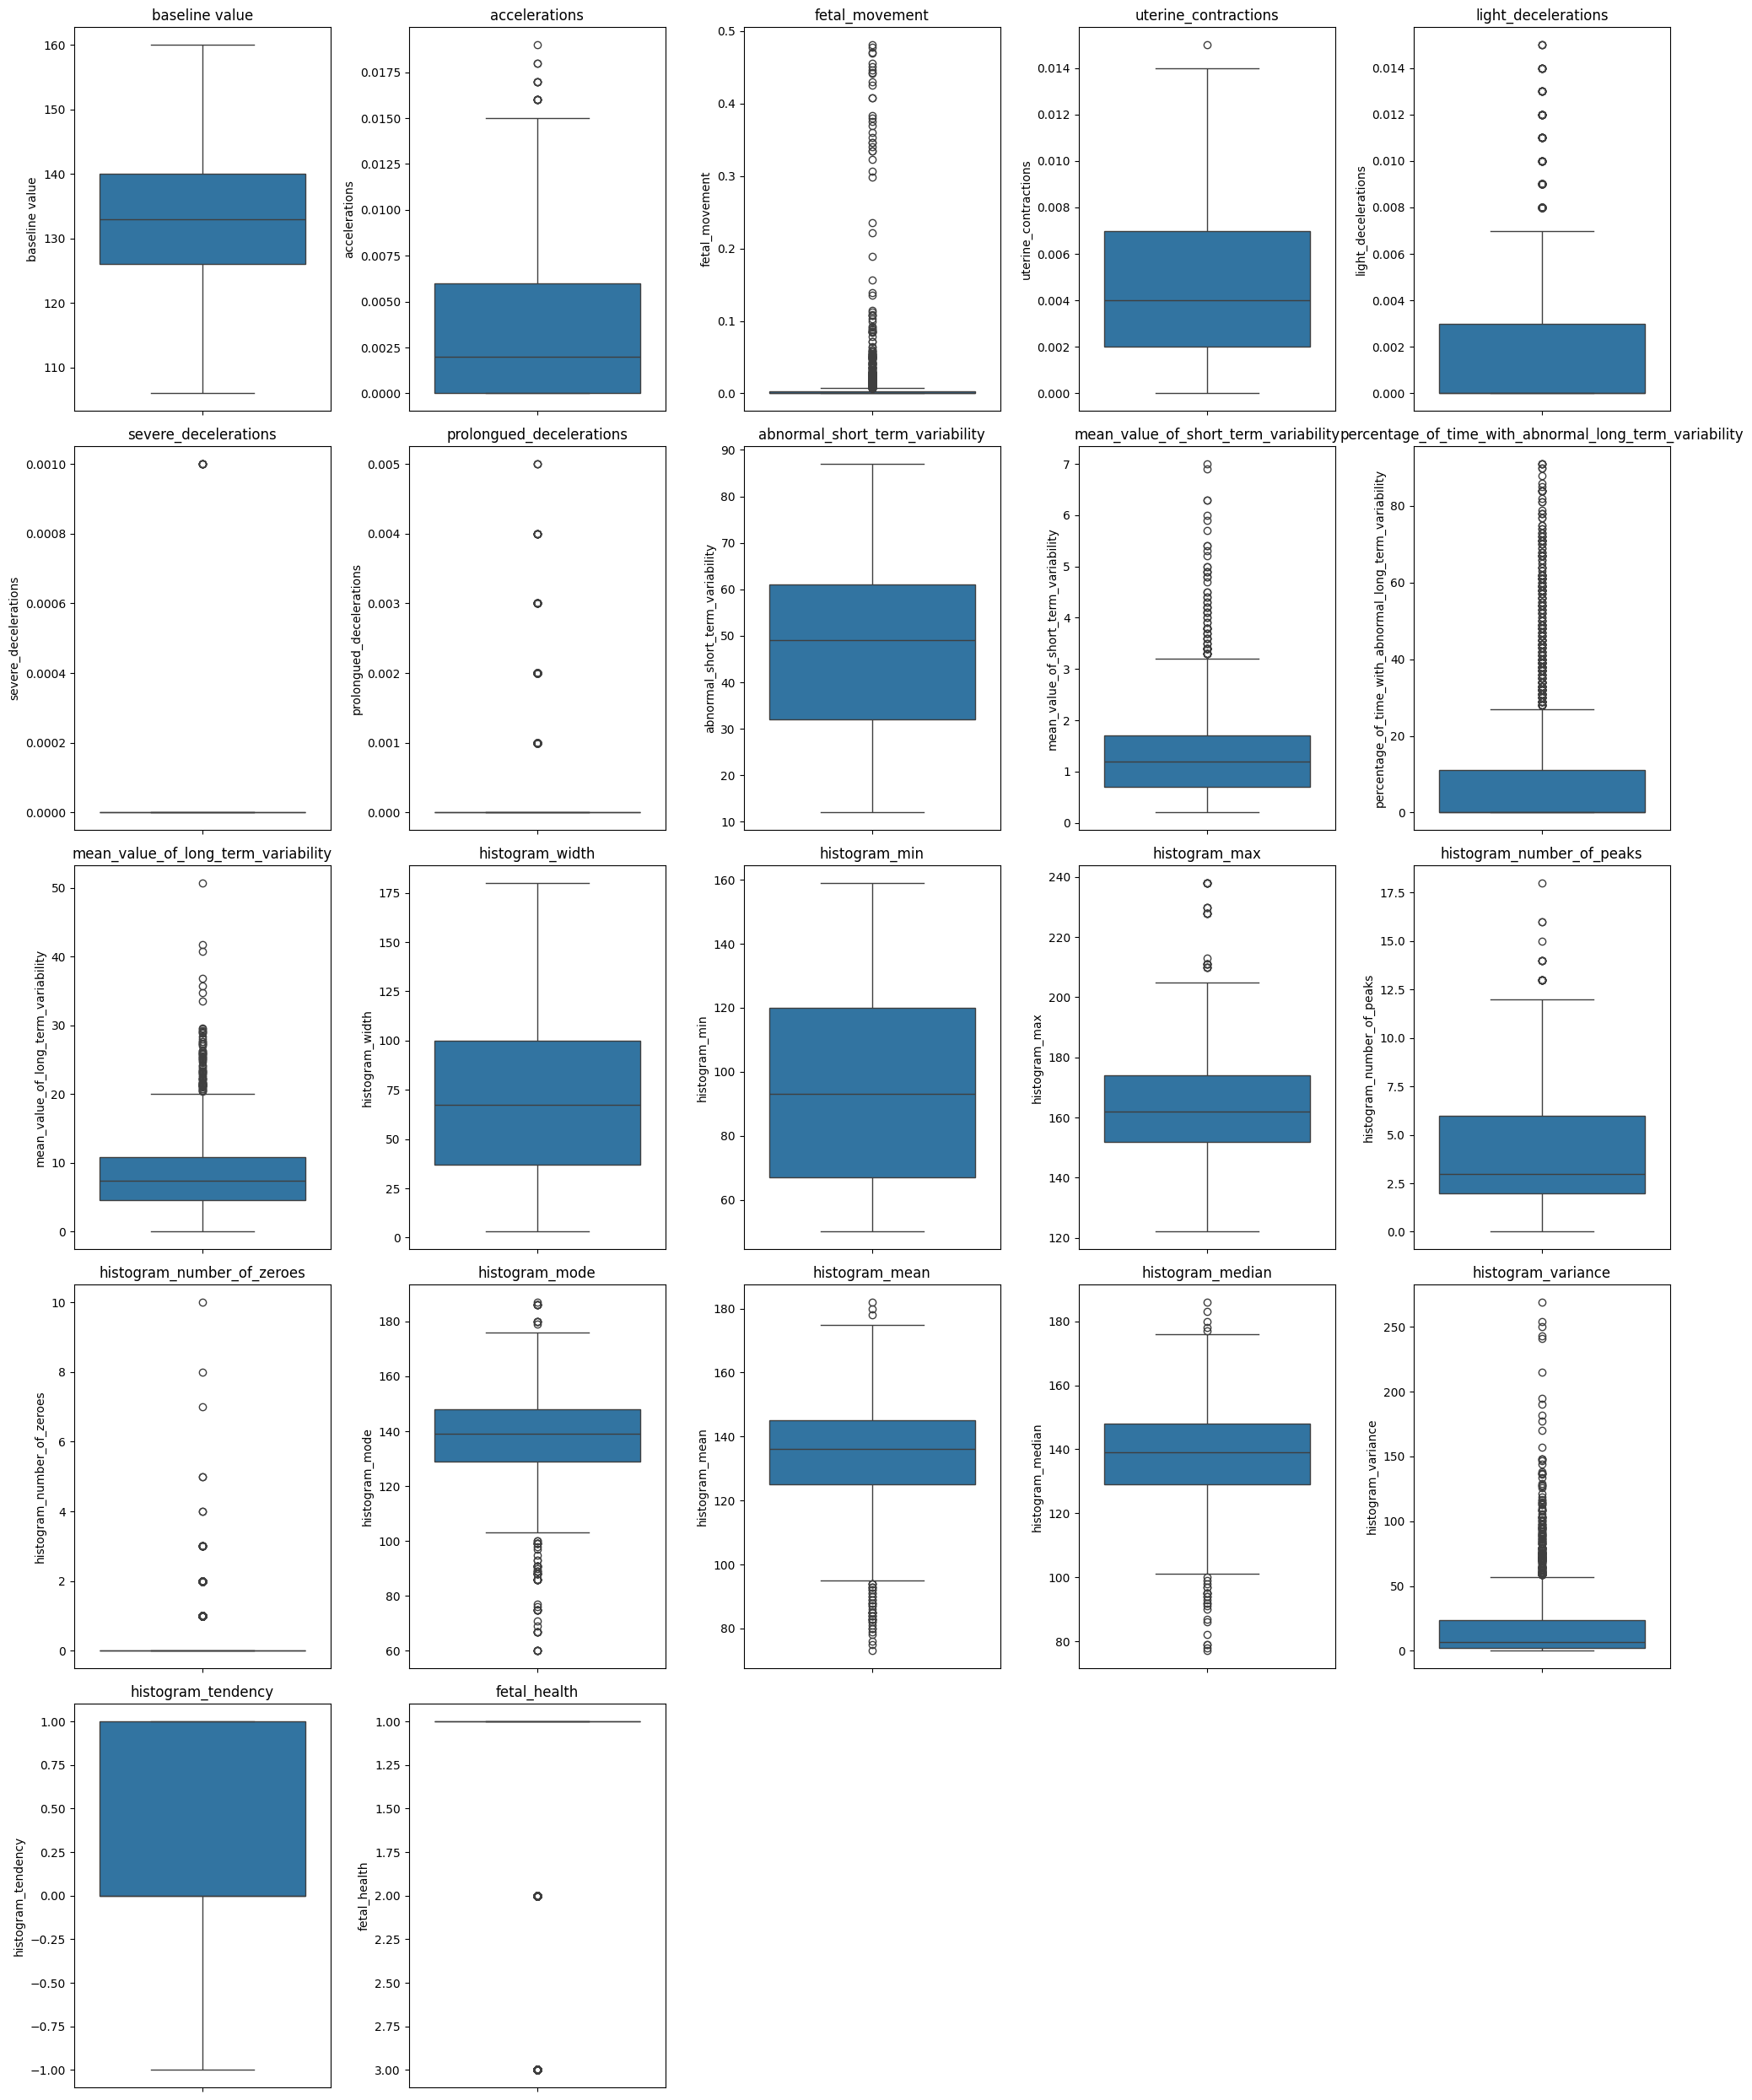

In [17]:
# Define the number of columns per row
columns_per_row = 5

# Calculate the number of rows
num_rows = (len(data.columns) + columns_per_row - 1) // columns_per_row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(20, 5*num_rows))

# Flatten axes if only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Plot boxplots
for i, column in enumerate(data.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(y=column, data=data, ax=axes[row, col])
    axes[row, col].set_title(column)

# Hide empty subplots
for i in range(len(data.columns), num_rows * columns_per_row):
    row = i // columns_per_row
    col = i % columns_per_row
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

## Boxplot pour chaque variable, avec distinction de classe

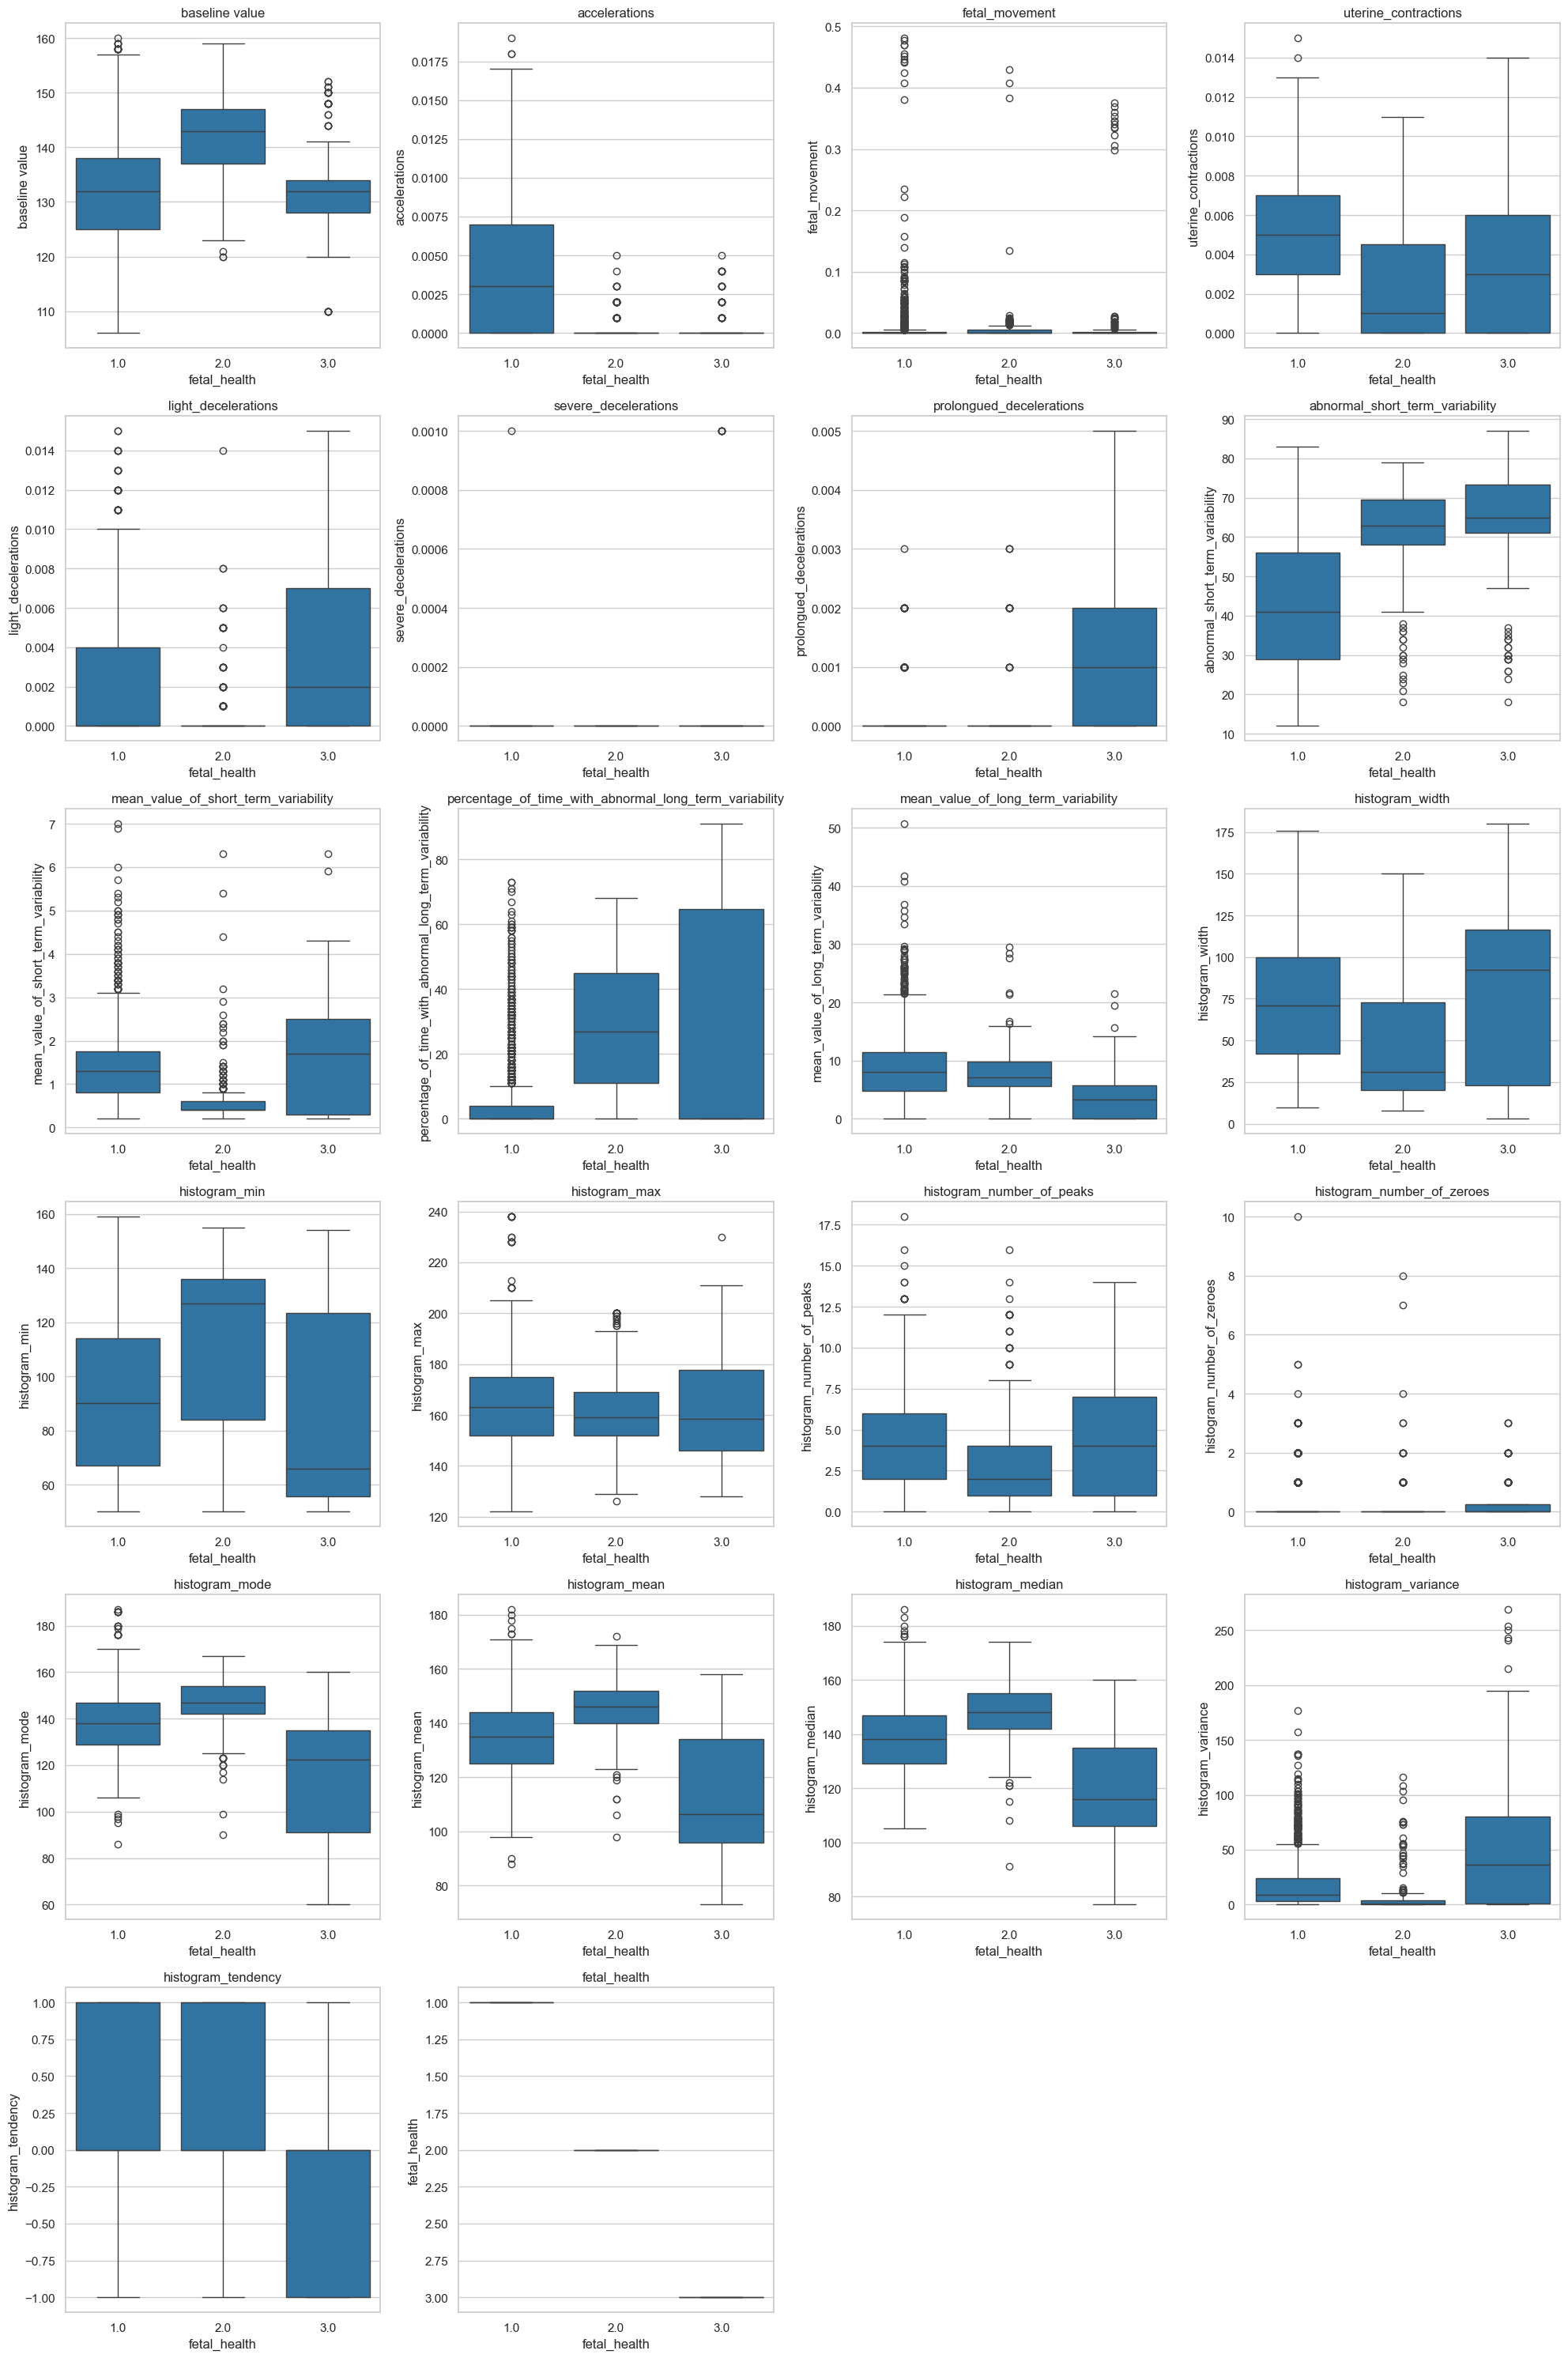

In [63]:
# Define the number of columns per row
columns_per_row = 4

# Calculate the number of rows
num_rows = (len(data.columns) + columns_per_row - 1) // columns_per_row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(20, 5*num_rows))

# Flatten axes if only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Plot boxplots
for i, column in enumerate(data.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(y=column, data=data, ax=axes[row, col], x=data.fetal_health)
    axes[row, col].set_title(column)

# Hide empty subplots
for i in range(len(data.columns), num_rows * columns_per_row):
    row = i // columns_per_row
    col = i % columns_per_row
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Calcul de corrélations

## Matrice de corrélation

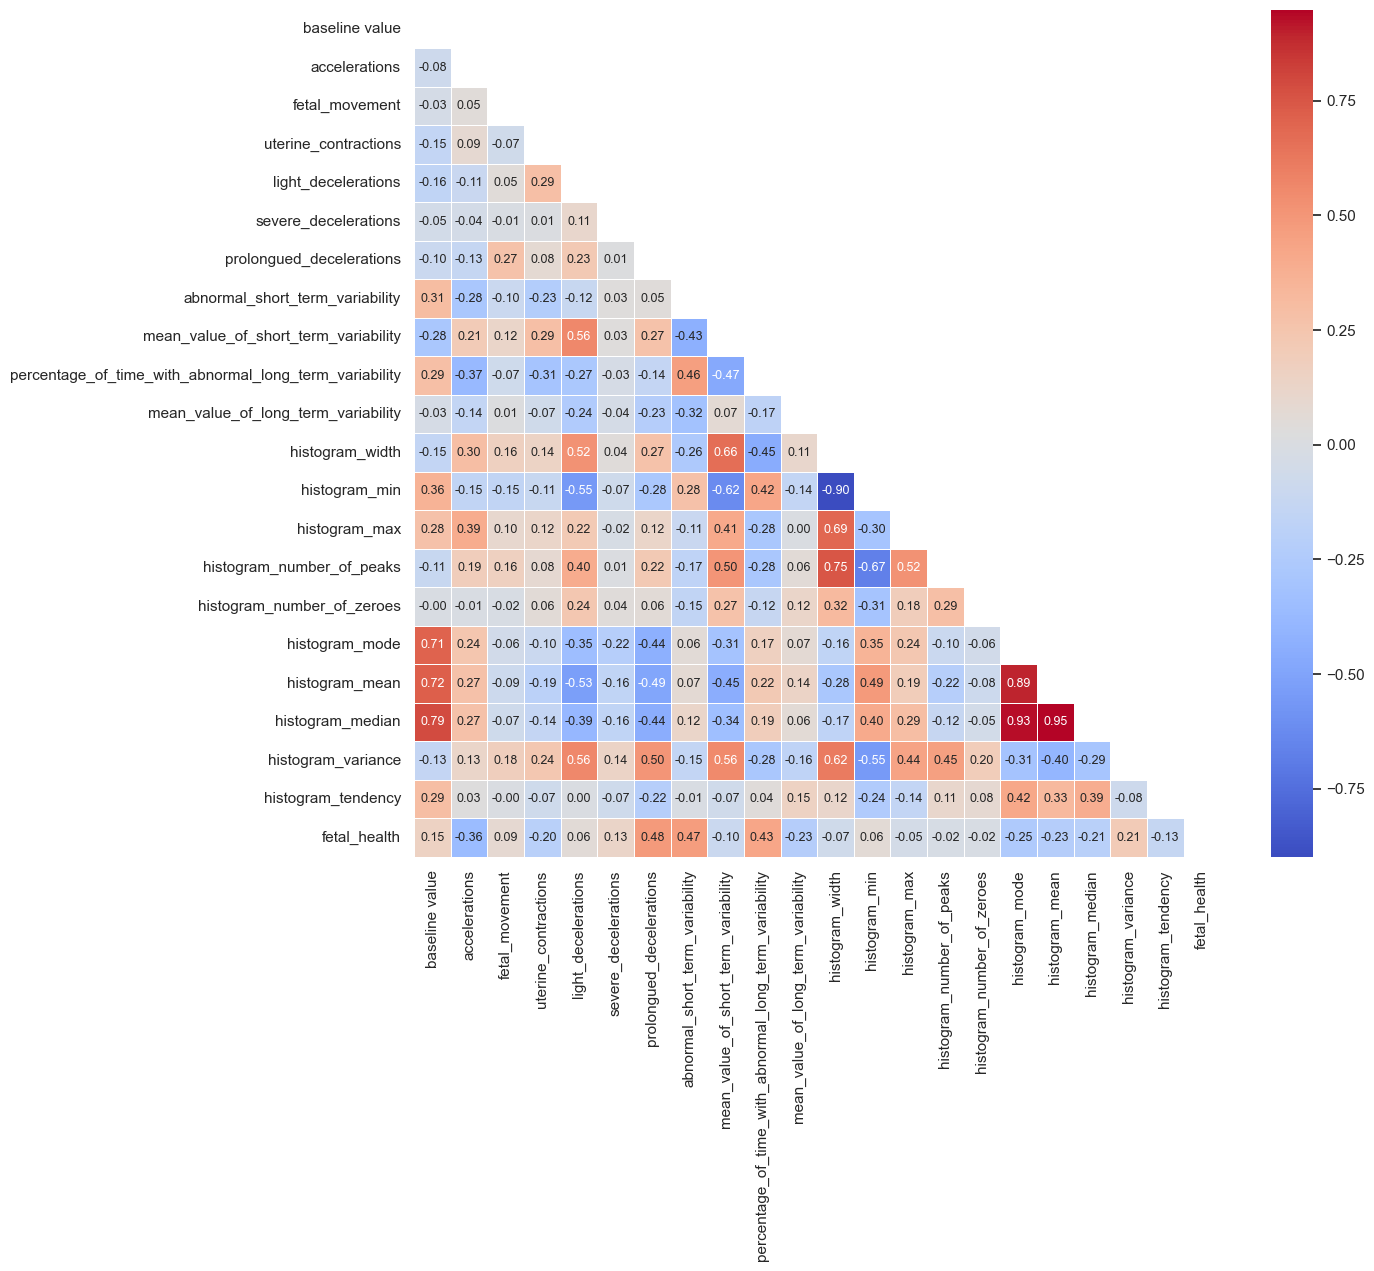

In [40]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(13, 11))
plt.grid(False)
sns.heatmap(corr, mask=mask, cmap='coolwarm', linewidths=0.5, annot=True, annot_kws={"fontsize":9}, fmt='.2f')
plt.show()

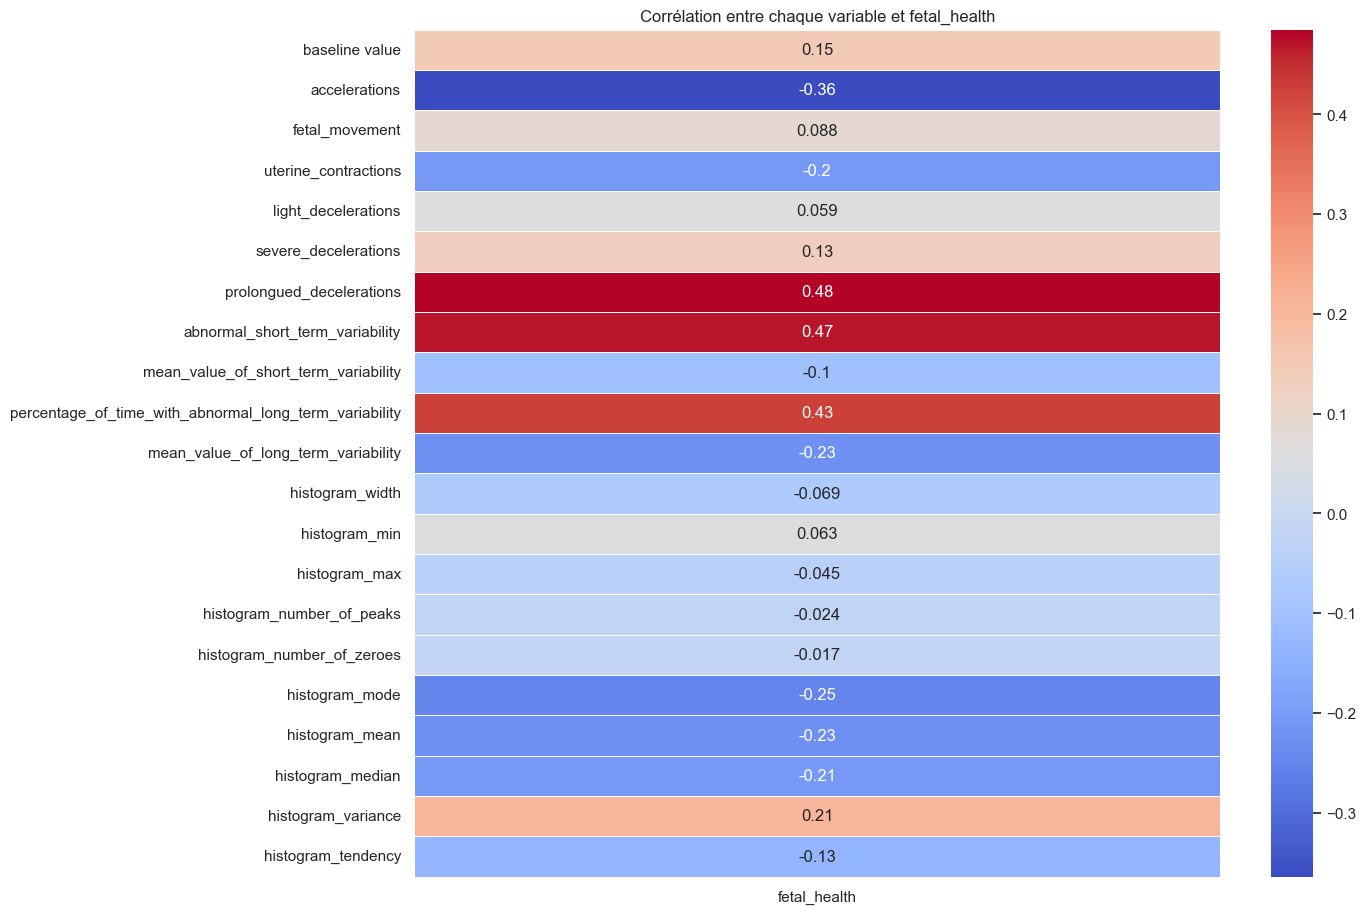

In [52]:


correlation_data = data.corr()['fetal_health']

# Créez un DataFrame à partir de la série de corrélation
correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.drop('fetal_health')

# Tracez la heatmap de la corrélation
plt.figure(figsize=(13, 11))
plt.grid(False)
sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True)
plt.title('Corrélation entre chaque variable et fetal_health')
plt.show()

On remarque que les variables "accelerations","prolongued_decelerations", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" et "mean_value_of_long_term_variability" sont celles qui sont le plus corrélé  à la santé du foetus

# Analyse en Composantes principales (ACP)

## Pourcentages d'inertie expliquée

Part d'inertie expliquée par chaque composante:
[0.589, 0.161, 0.097, 0.07, 0.037, 0.028, 0.006, 0.005, 0.004, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


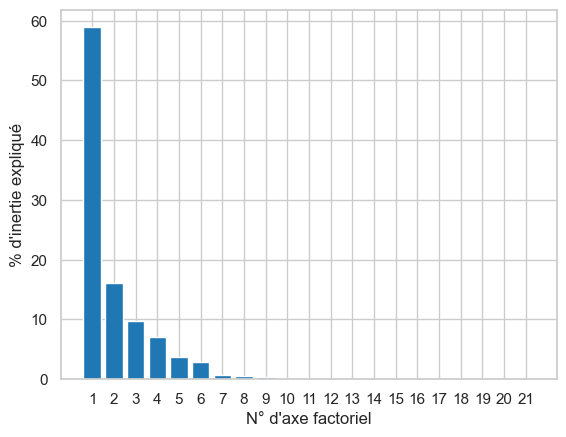

In [22]:
data_without_class = data.drop('fetal_health', axis=1)
cls = PCA(n_components=21)
pcs = cls.fit_transform(data_without_class)
print(f"Part d'inertie expliquée par chaque composante:\n{[round(value, 3) for value in cls.explained_variance_ratio_]}")

plt.bar([f"{i}" for i in range(1, 22)], cls.explained_variance_ratio_*100)
plt.xlabel("N° d'axe factoriel")
plt.ylabel("% d'inertie expliqué")
plt.show()

On remarque qu'à partir du 3° axe factoriel, le pourcentage d'inertie expliquée est faible voir très faible.
Les axes factoriels 1 et 2 expliquent 74% de l'inertie. 

## Représentation dans le premier plan factoriel

In [23]:
fig = px.scatter(x=pcs.T[0], y=pcs.T[1], color=data['fetal_health'], 
                 labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig.show()

On remarque, dans une certaine mesure que les observations de même classe sont rassemblées. Mais les clusters sont souvent confondus donc, en l'état (avec seulement une représentation dans le plan), on aura du mal à prédire la classe avec un algorithme de clustering.

# Méthodes de clustering

## Algorithmes des K-Means

In [24]:
def kmeans_generator(dataset, n_clusters_list):
    for n_clusters in n_clusters_list:
        cls = KMeans(n_clusters=n_clusters, init="k-means++",)
        km = cls.fit(dataset)
        inertia = km.inertia_
        yield n_clusters, inertia


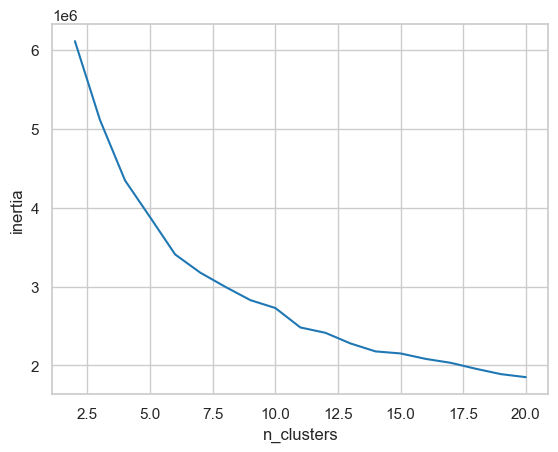

In [25]:
gen = kmeans_generator(data_without_class, [i for i in range(2,21)],)

elbow = pd.DataFrame(gen, columns=["n_clusters", "inertia"])
elbow = elbow.astype({"n_clusters": "int32"})
sns.lineplot(elbow, x="n_clusters", y="inertia")
plt.show()